# Fraud Detection of Credit Cart Transaction

## 1. Loading data

In [77]:
import pymysql 
import numpy as np
import datetime
import pandas as pd
import json
from matplotlib import pyplot as plt
from scipy.stats import chi2_contingency
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [78]:
#Befor runnning the code please upload the file "transactions.txt " to your jupyter environment to run the code.
data=[json.loads(line) for line in open('transactions.txt','r')]
#importing with dictionary form from JSON file
df=pd.DataFrame.from_dict(data)
#making into Dataframe form from dictionary form
df=df.replace(r'^\s*$', np.nan, regex=True)
#Replace empty to NaN

Data loaded into python pandas data frame from original JSON format.

In [79]:
pd.options.display.max_rows=300
pd.options.display.max_columns=60 #To see all the columns
df.head(2)


,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud
0,737265056,737265056,5000.0,5000.0,2016-08-13T14:27:32,98.55,Uber,US,US,02,01,rideshare,06/2023,2015-03-14,2015-03-14,414,414,1803,PURCHASE,NaN,0.0,NaN,NaN,NaN,False,NaN,NaN,False,False
1,737265056,737265056,5000.0,5000.0,2016-10-11T05:05:54,74.51,AMC #191138,US,US,09,01,entertainment,02/2024,2015-03-14,2015-03-14,486,486,767,PURCHASE,NaN,0.0,NaN,NaN,NaN,True,NaN,NaN,False,False


In [80]:
print(df.shape)
#Printing out the data structure

(786363, 29)


There are 786363 transaction cases (rows) with 29 columns

## 2. Summary statistics for the features

First, there will be handling of missing values in the data.

In [81]:
df.info() #skimming datatype and missing

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 786363 entries, 0 to 786362

Data columns (total 29 columns):

 #   Column                    Non-Null Count   Dtype  

---  ------                    --------------   -----  

 0   accountNumber             786363 non-null  object 

 1   customerId                786363 non-null  object 

 2   creditLimit               786363 non-null  float64

 3   availableMoney            786363 non-null  float64

 4   transactionDateTime       786363 non-null  object 

 5   transactionAmount         786363 non-null  float64

 6   merchantName              786363 non-null  object 

 7   acqCountry                781801 non-null  object 

 8   merchantCountryCode       785639 non-null  object 

 9   posEntryMode              782309 non-null  object 

 10  posConditionCode          785954 non-null  object 

 11  merchantCategoryCode      786363 non-null  object 

 12  currentExpDate            786363 non-null  object 

 13  accountOpenDate           

In [82]:
df.isna().sum() #count number of missing values for each column

accountNumber                    0
customerId                       0
creditLimit                      0
availableMoney                   0
transactionDateTime              0
transactionAmount                0
merchantName                     0
acqCountry                    4562
merchantCountryCode            724
posEntryMode                  4054
posConditionCode               409
merchantCategoryCode             0
currentExpDate                   0
accountOpenDate                  0
dateOfLastAddressChange          0
cardCVV                          0
enteredCVV                       0
cardLast4Digits                  0
transactionType                698
echoBuffer                  786363
currentBalance                   0
merchantCity                786363
merchantState               786363
merchantZip                 786363
cardPresent                      0
posOnPremises               786363
recurringAuthInd            786363
expirationDateKeyInMatch         0
isFraud             

Six features only have NaN for every row that is not informative. So, those columns will be dropped.

In [83]:
df=df.drop(['echoBuffer', 'merchantCity','merchantState','merchantZip','posOnPremises','recurringAuthInd'], axis=1) # dropping six columns

In [84]:
df.describe() #Summary statistics for continuous variables

,creditLimit,availableMoney,transactionAmount,currentBalance
count,786363.000000,786363.000000,786363.000000,786363.000000
mean,10759.464459,6250.725369,136.985791,4508.739089
std,11636.174890,8880.783989,147.725569,6457.442068
min,250.000000,-1005.630000,0.000000,0.000000
25%,5000.000000,1077.420000,33.650000,689.910000
50%,7500.000000,3184.860000,87.900000,2451.760000
75%,15000.000000,7500.000000,191.480000,5291.095000
max,50000.000000,50000.000000,2011.540000,47498.810000


These are summary statistics of the continuous variables that are monetary values. 
 I can check that the limits of credit are under \\$50,000 dollars and usually around \\$10,000. These features do not have missing values, so there is no need to conduct missing imputations for them. 

For the categorical features, I will treat them as one of the categories 'Unknown'.

In [85]:
df=df.replace(np.nan,'Unknown') # change NaN to Unknown 

In [86]:
df.nunique()

accountNumber                 5000
customerId                    5000
creditLimit                     10
availableMoney              521916
transactionDateTime         776637
transactionAmount            66038
merchantName                  2490
acqCountry                       5
merchantCountryCode              5
posEntryMode                     6
posConditionCode                 4
merchantCategoryCode            19
currentExpDate                 165
accountOpenDate               1820
dateOfLastAddressChange       2184
cardCVV                        899
enteredCVV                     976
cardLast4Digits               5246
transactionType                  4
currentBalance              487318
cardPresent                      2
expirationDateKeyInMatch         2
isFraud                          2
dtype: int64

The data is 5000 customer IDs,  and the number gives the impression that the data is intentionally cut into 5000 for the convenience of this data challenge. We need to check whether the id and account number are the same thing. Also, We need to see categorical variables that might be informative for the modeling.


In [87]:
(df.accountNumber!=df.customerId).sum() #total number of rows for the mismatch between those columns

0

The counts of difference in accountNumber and customerId is zero, so I can consider them as a same feature for this data.


In [88]:
df[['acqCountry']].value_counts()

acqCountry
US            774709
Unknown         4562
MEX             3130
CAN             2424
PR              1538
dtype: int64

In [89]:
df[['cardPresent']].value_counts()

cardPresent
False          433495
True           352868
dtype: int64

In [90]:
df[['posEntryMode']].value_counts()

posEntryMode
05              315035
09              236481
02              195934
90               19576
80               15283
Unknown           4054
dtype: int64

In [91]:
df[['transactionType']].value_counts()

transactionType     
PURCHASE                745193
REVERSAL                 20303
ADDRESS_VERIFICATION     20169
Unknown                    698
dtype: int64

In [92]:
df[['isFraud']].value_counts()

isFraud
False      773946
True        12417
dtype: int64

These are value counts for each category for some categorical variables in the data. The isFraud is the target variable for predictive modeling in the later part. I can see that there are lot more False than True.

## 3. Exploratory analysis

### transaction amount by transaction type.

array([[<AxesSubplot:title={'center':'ADDRESS_VERIFICATION'}>,
        <AxesSubplot:title={'center':'PURCHASE'}>],
       [<AxesSubplot:title={'center':'REVERSAL'}>,
        <AxesSubplot:title={'center':'Unknown'}>]], dtype=object)

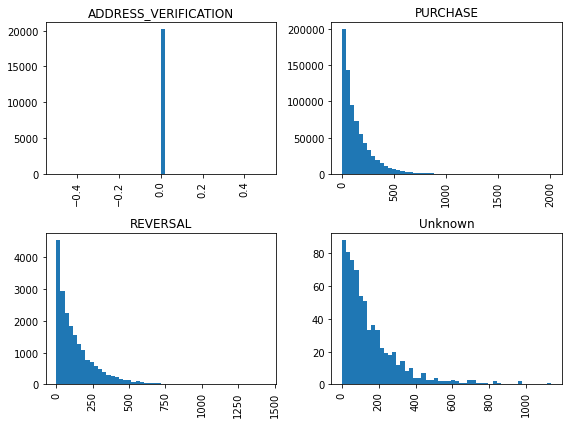

In [93]:
df2=df.copy()
#Copy from df in Q1
df2['transactionAmount'].hist(by=df2['transactionType'],bins=50,figsize=(8,6)) # histogram by transaction type

In [94]:
df2[['transactionType']].value_counts()

transactionType     
PURCHASE                745193
REVERSAL                 20303
ADDRESS_VERIFICATION     20169
Unknown                    698
dtype: int64

There are only 698 unknown transactions, so it seems almost ignorable.
The address verification is not an actual transaction that money flows.
Purchases are mostly under \\$500, and it is skewed to the right. Most of the transactions are happening in cheap buying.
Reversal of the purchase is also similar to the purchase with slightly more expensive transactions included.

It is natural to think that fraud transactions will be more pricy than normal transactions. To check this hypothesis, I compared transactionAmount between fraud and non-fraud transactions.

array([<AxesSubplot:title={'center':'False'}>,
       <AxesSubplot:title={'center':'True'}>], dtype=object)

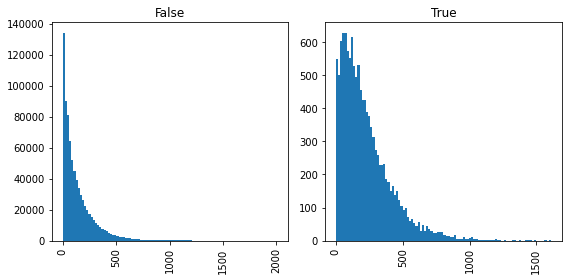

In [96]:
df2['transactionAmount'].hist(by=df2['isFraud'],bins=100) #histogram of transaction amount group by isFraud

In [97]:
def compare_frauds(data,par):
    nfrd = data.loc[data["isFraud"] == 0][par].rename("NoFraud").describe()
    frd = data.loc[data["isFraud"] == 1][par].rename("Fraud").describe()
    comb = nfrd.to_frame().join(frd.to_frame())
    return comb
#A functioon to show summary statistics of transaction amount for fraud and no fraud cases.
compare_frauds(df2,"transactionAmount")

,NoFraud,Fraud
count,773946.000000,12417.000000
mean,135.570249,225.215905
std,146.525305,189.551393
min,0.000000,0.000000
25%,33.190000,86.000000
50%,86.760000,176.980000
75%,189.390000,311.460000
max,2011.540000,1608.350000


As expected, Fraud transactions tend to have greater transaction amounts.

It is possible to have different transaction trend in different time. To check the effect of hour, day, month and year, I will preprocess transactionDateTime to separate column for each of time unit.

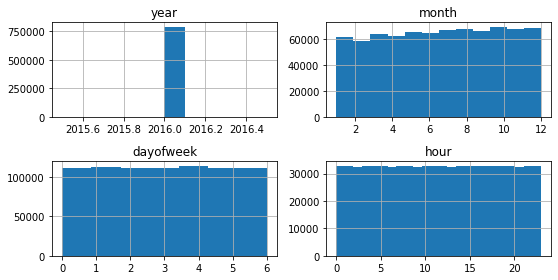

In [99]:

df2['hour']=pd.DatetimeIndex(df2['transactionDateTime']).hour
df2['dayofweek']=pd.DatetimeIndex(df2['transactionDateTime']).dayofweek
df2['month']=pd.DatetimeIndex(df2['transactionDateTime']).month
df2['year']=pd.DatetimeIndex(df2['transactionDateTime']).year
#Extracting each of time unit for'transactionDateTime'

#fig, axs=plt.subplots(5,1,sharey=True,tight_layout=True)

plt.rcParams["figure.figsize"] = [8, 4]
plt.rcParams["figure.autolayout"] = True



fig, axes = plt.subplots(2, 2)
#2x2 plots for 4 histograms
df2.hist('year', ax=axes[0,0])
df2.hist('month', ax=axes[0,1],bins=12)
df2.hist('dayofweek', ax=axes[1,0],bins=7)
df2.hist('hour', ax=axes[1,1],bins=24)
plt.show()


It shows that the data is transaction data for 2016. There is some difference at different times. Will it be related to the fraud? I will check transaction distribution at different hours for non-fraud and fraud transactions.

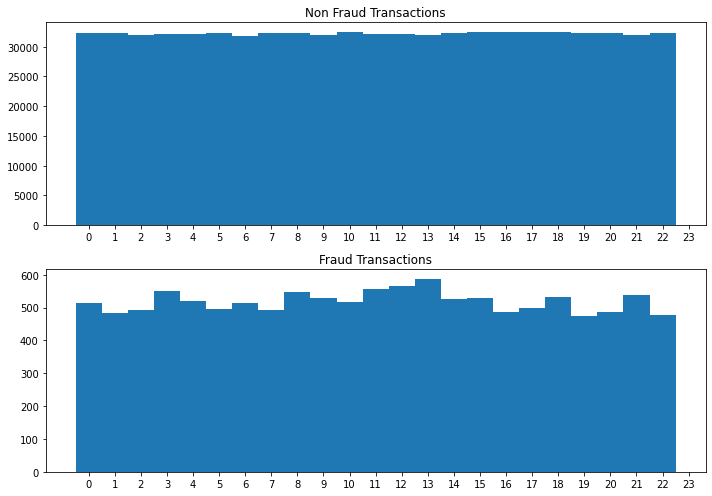

In [100]:
fig, ax = plt.subplots(2, figsize=(10,7))
for a in ax:
    a.set_xticks(range(24))
df2.loc[df3["isFraud"] == 0]["hour"].hist(bins=np.arange(24)-0.5, ax=ax[0], grid=False)
df2.loc[df3["isFraud"] == 1]["hour"].hist(bins=np.arange(24)-0.5, ax=ax[1], grid=False)
ax[0].title.set_text("Non Fraud Transactions")
ax[1].title.set_text("Fraud Transactions")
plt.subplots_adjust(hspace=0.3)

We can see that fraud transactions tend to be less uniform across the transactions. This might work as a good predictor for Fraud detection.

One feature that seems interesting was cardPresent, because typical fraud happens when the card is still in one's hands.  We may check the transaction amount for cardPresent and non-present depending on fraud and non-fraud transactions.

Text(0, 0.5, 'transactionAmount')

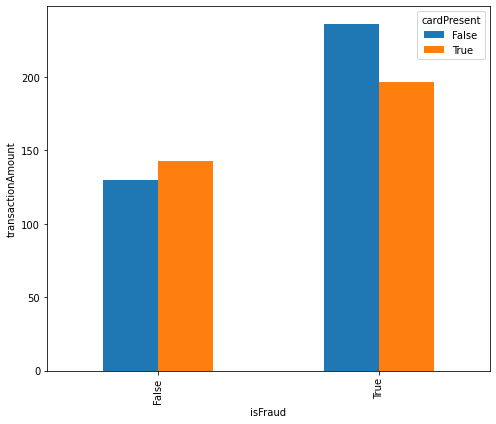

In [101]:
#pvoting to draw bar graph with two groups
df_pivot = pd.pivot_table(
    df2, 
    values="transactionAmount",
    index="isFraud",
    columns="cardPresent", 
    aggfunc=np.mean
) #np.mean for mean transaction amount
ax = df_pivot.plot(kind="bar")
fig = ax.get_figure()
fig.set_size_inches(7, 6)
ax.set_xlabel("isFraud")
ax.set_ylabel("transactionAmount")

For fraud transactions, the mean amount of transactions was much higher when the card was not present. 

## 4. Data wragling

### Reversed transaction

Here are codes to create an indicator column for reversed transactions. The logic is explained in comments inside the code.

In [102]:
df3=df2.copy() #copy data from q2
df3['indexer']=df3.index #
df3['Rev_indicator']="NO" #df3 is the data frame that will get the indicator column

df4=df3.copy() #temporary dataframe to get index for the rows of interest
df4_rev=df4[(df4['transactionType']=='REVERSAL')] # subset for reversal data
df4 = df4.merge(df4_rev, how='left', left_on=["customerId", "transactionAmount","merchantName"], right_on=["customerId", "transactionAmount","merchantName"])
#Joining back the reversal subset to the full data to find reversal relevant rows
df_time_filtered=df4[df4.transactionDateTime_x<df4.transactionDateTime_y]
#use only for the transactions happened earlier than the reversal transaction.
df_pur_filtered=df_time_filtered[df_time_filtered['transactionType_x']=='PURCHASE']
#subsetting purchase data only among reversal-related data
df_maxtime=df_pur_filtered.groupby(by=['customerId','transactionAmount','merchantName']).max('transactionDateTime_x')
#finding the latest transactions correspond to the reversal transaction 
#Change selected to temporary data.
df3.at[df3.index.isin(df_maxtime.indexer_x),"Rev_indicator"]= "YES"
#apply index to df3
df3[df3['Rev_indicator']=="YES"]


,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud,hour,dayofweek,month,year,indexer,Rev_indicator
38,574788567,574788567,2500.0,2416.11,2016-05-24T01:35:33,215.13,Convenient Tire,US,US,09,01,auto,10/2021,2015-10-13,2015-10-13,206,206,8522,PURCHASE,83.89,True,False,False,1,1,5,2016,38,YES
100,924729945,924729945,50000.0,50000.00,2016-10-04T04:20:04,168.57,discount.com,US,US,05,01,online_retail,11/2024,2014-07-25,2014-07-25,205,265,9459,PURCHASE,0.00,False,False,False,4,1,10,2016,100,YES
113,984504651,984504651,50000.0,49138.85,2016-01-06T04:08:06,83.64,1st Sandwitch Bar #801388,US,US,09,01,food,11/2025,2015-07-27,2015-07-27,640,640,8332,PURCHASE,861.15,True,False,False,4,2,1,2016,113,YES
132,984504651,984504651,50000.0,46818.15,2016-01-16T09:52:30,450.74,Planet Fitness #849960,US,US,05,01,health,08/2028,2015-07-27,2015-07-27,640,640,8332,PURCHASE,3181.85,False,False,False,9,5,1,2016,132,YES
138,984504651,984504651,50000.0,46341.05,2016-01-17T08:13:08,81.73,AMC #724446,US,US,09,01,entertainment,12/2031,2015-07-27,2015-07-27,640,640,8332,PURCHASE,3658.95,True,False,False,8,6,1,2016,138,YES
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
786013,205026043,205026043,5000.0,1627.52,2016-09-18T06:07:17,56.26,Lyft,US,US,05,01,rideshare,07/2031,2008-04-15,2008-04-15,359,359,258,PURCHASE,3372.48,False,False,False,6,6,9,2016,786013,YES
786070,288358186,288358186,7500.0,7407.25,2016-08-02T18:42:42,20.66,ebay.com,US,US,09,01,online_retail,09/2028,2014-08-21,2014-08-21,355,355,1665,PURCHASE,92.75,False,False,False,18,1,8,2016,786070,YES
786119,638498773,638498773,10000.0,10000.00,2016-01-01T19:45:47,201.79,KFC #928167,US,US,05,01,fastfood,11/2032,2014-11-17,2014-11-17,175,175,321,PURCHASE,0.00,True,False,False,19,4,1,2016,786119,YES
786207,638498773,638498773,10000.0,1271.91,2016-10-09T04:52:23,86.14,Dunkin' Donuts #396342,US,US,05,01,fastfood,03/2025,2014-11-17,2014-11-17,387,387,4635,PURCHASE,8728.09,True,False,False,4,6,10,2016,786207,YES


In [103]:
print(df3[df3['Rev_indicator']=="YES"].shape[0], df3[df3['Rev_indicator']=="YES"]['transactionAmount'].sum())

17756 2666451.8


There are 17756 cases of reversed transaction and the total dollar amount of reversed transaction is $2,666,451.8.

### Multi-swipe transaction

Here are codes to create an indicator column for multi-swipe transactions. The logic is explained in comments inside the code. It is uncertain that the multi-swipe transaction can happen in which size of a time window. This time 10 minutes were selected arbitrarily.

In [104]:

#Continuing from df3 made for reversed transaction
df3['Multi_indicator']="NO"
df3_m=df3[(df3['transactionType']=='PURCHASE')] 
# subset for only purchase data
df3_m.loc[:,'timewindow']=pd.to_datetime(df3_m['transactionDateTime'])
df3_m.loc[:,'timewindow_lower']=pd.to_datetime(df3_m['transactionDateTime'])-datetime.timedelta(minutes=10)
df3_m.loc[:,'timewindow_upper']=pd.to_datetime(df3_m['transactionDateTime'])+datetime.timedelta(minutes=10)
#Creating time 10 minute window for a transaction.
df3_m['Multi_all']=df3_m.duplicated(["customerId", "transactionAmount","merchantName"],keep=False)
#Temporary indictor for transactions that has duplicated transactions in terms of id, smount and merchant 
#(does not mean they are multi swipe though)
df3_m['Multi_error']=df3_m.duplicated(["customerId", "transactionAmount","merchantName"],keep='first')
#Give false for first transaction first transaction is normal not multiswiped
df3_m_merged=df3_m[df3_m['Multi_all']==True].merge(df3_m[(df3_m['Multi_all']==True) & (df3_m['Multi_error']==False)], 
                                                   how='left', left_on=["customerId", "transactionAmount","merchantName"], 
                                                   right_on=["customerId", "transactionAmount","merchantName"])
#merge dat to df3_m with multi transaction data to get indexer from it.
df3_m_2=df3_m_merged[((df3_m_merged['Multi_error_x']==False)| (df3_m_merged['Multi_error_x']==True)
     & (df3_m_merged['timewindow_y']>df3_m_merged['timewindow_lower_x'])  
     & (df3_m_merged['timewindow_y']<df3_m_merged['timewindow_upper_x']))]
#add time filter makes out of window is not to be considered as a multi-swipe transaction
df3.at[df3.index.isin(df3_m_2[df3_m_2['Multi_error_x']==True]['indexer_x']),"Multi_indicator"]= "YES"
#applying the index to the df3
df3[df3['Multi_indicator']=="YES"]



,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud,hour,dayofweek,month,year,indexer,Rev_indicator,Multi_indicator
263,984504651,984504651,50000.0,26680.99,2016-03-12T06:34:29,118.52,AMC #706324,US,US,02,01,entertainment,10/2024,2015-07-27,2015-07-27,640,640,8332,PURCHASE,23319.01,True,False,False,6,5,3,2016,263,NO,YES
264,984504651,984504651,50000.0,26562.47,2016-03-12T06:36:41,118.52,AMC #706324,US,US,02,01,entertainment,10/2024,2015-07-27,2015-07-27,640,640,8332,PURCHASE,23437.53,True,False,False,6,5,3,2016,264,NO,YES
281,984504651,984504651,50000.0,24316.12,2016-03-18T13:57:04,26.71,Planet Fitness #692929,US,US,02,01,health,10/2024,2015-07-27,2015-07-27,640,640,8332,PURCHASE,25683.88,True,False,False,13,4,3,2016,281,NO,YES
339,984504651,984504651,50000.0,16503.49,2016-04-08T22:21:11,43.21,WSC #994275,US,US,02,08,health,02/2030,2015-07-27,2016-03-26,640,640,8332,PURCHASE,33496.51,False,False,False,22,4,4,2016,339,NO,YES
413,984504651,984504651,50000.0,7302.32,2016-05-07T07:32:54,23.82,Golds Gym #846582,US,US,09,01,health,12/2030,2015-07-27,2016-05-05,640,640,8332,PURCHASE,42697.68,True,False,False,7,5,5,2016,413,NO,YES
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
785758,207667444,207667444,7500.0,6893.70,2016-10-14T13:24:58,79.82,discount.com,US,US,02,01,online_retail,03/2025,2011-12-12,2016-08-16,235,235,9853,PURCHASE,606.30,False,False,False,13,4,10,2016,785758,NO,YES
785915,428856030,428856030,250.0,104.44,2016-10-30T20:59:18,314.07,Rodeway Inn #438868,US,US,02,01,hotels,02/2027,2009-08-17,2009-08-17,990,990,7660,PURCHASE,145.56,True,False,False,20,6,10,2016,785915,NO,YES
785983,205026043,205026043,5000.0,451.59,2016-06-07T22:29:11,391.94,Uber,US,US,09,08,rideshare,12/2029,2008-04-15,2008-04-15,198,198,3931,PURCHASE,4548.41,False,False,False,22,1,6,2016,785983,NO,YES
785984,205026043,205026043,5000.0,433.52,2016-06-07T22:30:57,391.94,Uber,US,US,09,08,rideshare,12/2029,2008-04-15,2008-04-15,198,198,3931,PURCHASE,4566.48,False,False,False,22,1,6,2016,785984,NO,YES


In [105]:
print(df3[df3['Multi_indicator']=="YES"].shape[0], df3[df3['Multi_indicator']=="YES"]['transactionAmount'].sum())

7429 1102003.3299999998


There are 7429 cases of multi-swiped transaction and the total dollar amount of reversed transaction is //$1,102,003.

Here are some contingency tables for isFraud and the indicator just created

In [106]:
contingency= pd.crosstab(df3["isFraud"], df3["Rev_indicator"]) #2x2 contigency table with count
contingency


Rev_indicator,NO,YES
isFraud,,
False,756493,17453
True,12114,303


In [107]:
contingency_pct = pd.crosstab(df3["isFraud"], df3["Rev_indicator"], normalize='index') #2x2 contigency table with pct
contingency_pct

Rev_indicator,NO,YES
isFraud,,
False,0.977449,0.022551
True,0.975598,0.024402


In [108]:
c, p, dof, expected = chi2_contingency(contingency)
p # Getting p-value for the chisquare test.

0.17791158543034952

Chi square test is used to test the independece of two categorical features of interest. The proportional difference in fraud for reversed transactions does not show a statistical difference.

In [109]:
contingency= pd.crosstab(df3["isFraud"], df3["Multi_indicator"]) #2x2 contigency table with count
contingency

Multi_indicator,NO,YES
isFraud,,
False,766645,7301
True,12289,128


In [110]:
contingency_pct = pd.crosstab(df3["isFraud"], df3["Multi_indicator"], normalize='index') #2x2 contigency table with pct
contingency_pct

Multi_indicator,NO,YES
isFraud,,
False,0.990567,0.009433
True,0.989692,0.010308


In [111]:
c, p, dof, expected = chi2_contingency(contingency)
p # Getting p-value for the chisquare test.

0.3405188183914446

The proportional difference in fraud for multi-swiped and non-swiped transactions does not show a statistical difference.

## 5. Modeling
### Classficiation modeling for detection of fraduelent transaction


For this classification task, the most accessible model that can be used is the logistic regression model. Therefore, I will set the logistic regression model as a baseline model. The logistic regression model, specifically, a logistic regression model with l1 penalty (Lasso), will be used. The L1 penalty penalizes the predictors with weak predictive values and automatically penalizes and does not play in the model. 

The other approach is selected for one of the tree-based models. The model I am going to suggest is XGBoost. Maybe the most well-known tree-based model is Random Forest. The naive comparison of Random forest and XGBoost is that Random Forest decides the final model with a champion among different tree models. On the other hand, XGBoost refines from weaker tree to stronger tree.
I decided to use XGboost over Random forest because Xgboost works better for imbalanced classification tasks than random forest if I can avoid the possible overfitting in XGboost. Also, previous work experience told me that XGBoost is pretty reliable in classification and feature selection.

In addition to comparing logistic regression and Xgboost, I will compare the feature engineering that I have done during Q1~Q3 and some additional feature engineering. So first, I will just run with the original data I have with minimal preprocessing of data with just a dummy coding for categorical variables. Next, I will add additional predictors and run the same analysis for logistic regression and XG boost.


In [246]:
from numpy import loadtxt
import xgboost
from xgboost import XGBClassifier
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.model_selection import RepeatedStratifiedKFold
from collections import Counter
from sklearn.datasets import make_classification
from matplotlib import pyplot
from numpy import where
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import RepeatedStratifiedKFold
from xgboost import XGBClassifier
import random
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
#from imblearn.over_sampling import SMOTE
from xgboost import Booster
from xgboost import DMatrix
from sklearn import metrics
from datetime import datetime
import sklearn

In [247]:
df4=df3.copy() #df4 will be used for logistic regression and xgboost for minimal preprocessing of data.

In [248]:
tempdf=pd.get_dummies(df4.merchantCategoryCode, prefix='merchantCategoryCode')
df4=pd.concat([df4, tempdf], axis=1)
tempdf=pd.get_dummies(df4.transactionType, prefix='transactionType')
df4=pd.concat([df4, tempdf], axis=1)
tempdf=pd.get_dummies(df4.posEntryMode, prefix='posEntryMode')
df4=pd.concat([df4, tempdf], axis=1)
tempdf=pd.get_dummies(df4.acqCountry, prefix='acqCountry')
df4=pd.concat([df4, tempdf], axis=1)   

#Dummy coding for the categorical variable to be used
df4["isFraud"]=df4["isFraud"]*1
df4['cardPresent']=df4['cardPresent']*1
#just in case for error made it to numeric
df_train, df_test=train_test_split(df4,test_size=0.3,random_state=8,stratify=df4[['isFraud']])
# Stratified sampling of 70% training 30% test
train_counts=df_train['isFraud']
print(sum(df_train['isFraud'])/df_train.shape[0])
print(sum(df_test['isFraud'])/df_test.shape[0])
print(sum(df4['isFraud'])/df4.shape[0])
#To check the sratified sampling worked correctly
drops=['accountNumber',
 'customerId',
 'transactionDateTime',
      'merchantName',
 'acqCountry',
 'merchantCountryCode',
 'posEntryMode',
 'posConditionCode',
 'merchantCategoryCode',
 'currentExpDate',
 'accountOpenDate',
 'dateOfLastAddressChange',
 'cardCVV',
 'enteredCVV',
 'cardLast4Digits',
 'transactionType',
 'currentBalance',
 'expirationDateKeyInMatch',
       'Rev_indicator',
       'Multi_indicator',
      'hour',
       'dayofweek',
       'month',
       'year',
       'indexer']
#List of features to be dropped.

X_trainall = df_train.iloc[:, df_train.columns != 'isFraud']
X_train=X_trainall.drop(drops, axis = 1)
y_train = df_train.iloc[:, df_train.columns == 'isFraud']
X_testall = df_test.iloc[:, df_test.columns != 'isFraud']
X_test=X_testall.drop(drops, axis = 1)
y_test = df_test.iloc[:, df_test.columns == 'isFraud']
#Spliting train and test for X and y with dropping feautres not used for the modeling.


0.01579060193948995

0.015789986816950603

0.01579041740264992


The categorical variables are dummy coded. The training set and the test were sampled, and they will be used for both logistic regression and XGboost.

No Skill: ROC AUC=0.500

Logistic: ROC AUC=0.749


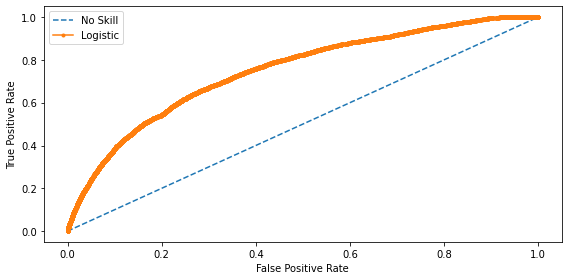

In [249]:
# roc curve and auc
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
model_logistic = LogisticRegression(penalty='l1',solver='liblinear')
model_logistic.fit(X_train, y_train)
model_logistic.score(X_test,y_test) 
#running logistic regression with L1 penalty

# predict probabilities
lr_probs = model_logistic.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_probs = [0 for _ in range(len(y_test))]
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

Logistic lasso regression showed AUC of 0.749.

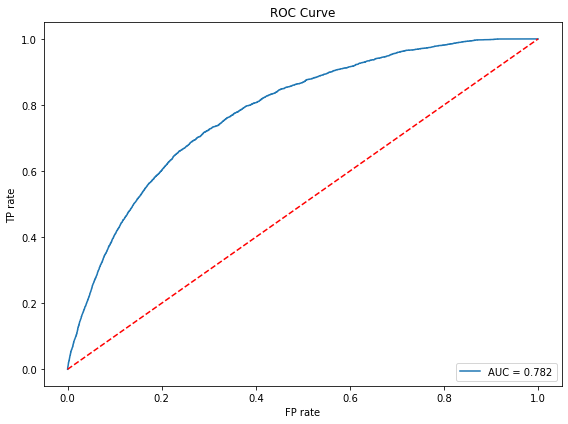

In [250]:
model_default = XGBClassifier(base_score=sum(df4['isFraud'])/df4.shape[0])
#XG BOOST with base_score using portion of fraud
model_default.fit(X_train, y_train)
y_pred_d = model_default.predict_proba(X_test)[:,1]
#Prediction of y_test

###process to generate ROC curve
fp_r, tp_r, t = metrics.roc_curve(y_test, y_pred_d)
auc = metrics.auc(fp_r, tp_r)
plt.figure(figsize=(8, 6))
plt.plot(fp_r, tp_r, label="AUC = %.3f" % auc)
plt.plot([0,1],[0,1],"r--")
plt.ylabel("TP rate")
plt.xlabel("FP rate")
plt.legend(loc=4)
plt.title("ROC Curve")
plt.show()
###

In [251]:
t_opt_idx = np.argmax(tp_r - fp_r)
t_opt = t[t_opt_idx]
print("Threshold value is: %.4f" % t_opt)

Threshold value is: 0.0155


The treshold value that maximize true positive rate - false positive rate is 0.0135. Let see how model behaves with other thresholds.

Text(0.5, 0.98, 'Impact of threshold adjustment on the error matrix')

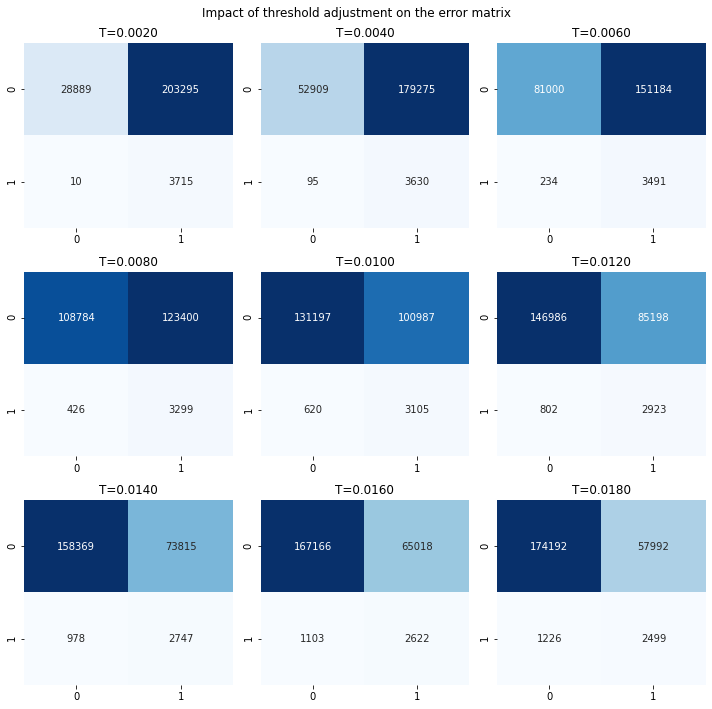

In [252]:
#Confusion matrix using different treshold
y_pred = model_default.predict_proba(X_test)[:,1]
fig, axes = plt.subplots(3,3, figsize=(10,10))
for t, ax in enumerate(axes.flat):
    threshold = round((t+1)/500,4)
    y_pred_int = (y_pred > threshold).astype(int)
    c_matrix = metrics.confusion_matrix(y_test, y_pred_int)
    sns.heatmap(c_matrix, annot=True, cmap="Blues", fmt="d", ax=ax, cbar=False)
    ax.title.set_text("T=%.4f" % threshold)
plt.subplots_adjust(hspace=0.5, wspace=0.5)
plt.suptitle("Impact of threshold adjustment on the error matrix")

Based on the purpose of the detection, one may choose a more aggressive (lower threshold) prediction or a more conservative (higher threshold) prediction. 

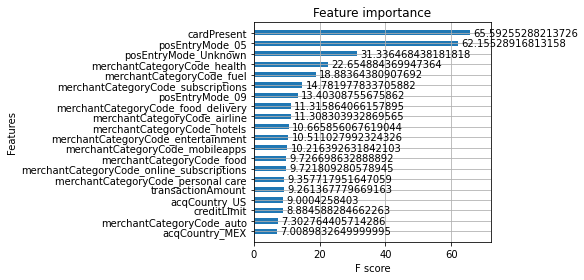

In [253]:
xgboost.plot_importance(model_default,  height=0.5, max_num_features=20, importance_type='gain')
plt.show()

These are important features that contribute to the prediction. The top two are cardPresent and poeEntryMode_05. I googled 'pos entry mode', and the 05 means 'Integrated circuit reader'. Using a chip physically also means the presence of a card, so they should be highly correlated features.

In [260]:
df5=df3.copy()

In [261]:
#
df5['TA_zscore']=(df5['transactionAmount'] - df5['transactionAmount'].mean()) / df5['transactionAmount'].std()
#Zscore for transaction amount
df5['TA_ZS_GRP']=df5.groupby('merchantCategoryCode')['transactionAmount'].transform(lambda x: (x-x.mean())/x.std())
#Zscore grouped by 'merchantCategoryCode'
df5['TA_ZS_POS']=df5.groupby('posEntryMode')['transactionAmount'].transform(lambda x: (x-x.mean())/x.std())
#Zscore grouped by 'posEntryMode'
df5['TA_ZS_hold']=df5.groupby('cardPresent')['transactionAmount'].transform(lambda x: (x-x.mean())/x.std())
#Zscore grouped by 'cardPresent'

#### Dummy coding 
tempdf=pd.get_dummies(df5.merchantCategoryCode, prefix='merchantCategoryCode')
df5=pd.concat([df5, tempdf], axis=1)
tempdf=pd.get_dummies(df5.transactionType, prefix='transactionType')
df5=pd.concat([df5, tempdf], axis=1)
tempdf=pd.get_dummies(df5.posEntryMode, prefix='posEntryMode')
df5=pd.concat([df5, tempdf], axis=1)
tempdf=pd.get_dummies(df5.acqCountry, prefix='acqCountry')
df5=pd.concat([df5, tempdf], axis=1)   
tempdf=pd.get_dummies(df5.acqCountry, prefix='hour')
df5=pd.concat([df5, tempdf], axis=1)  
tempdf=pd.get_dummies(df5.acqCountry, prefix='month')
df5=pd.concat([df5, tempdf], axis=1)  
tempdf=pd.get_dummies(df5.acqCountry, prefix='dayofweek')
df5=pd.concat([df5, tempdf], axis=1)  
tempdf=pd.get_dummies(df5.acqCountry, prefix='Rev_indicator')
df5=pd.concat([df5, tempdf], axis=1)  
tempdf=pd.get_dummies(df5.acqCountry, prefix='Multi_indicator')
df5=pd.concat([df5, tempdf], axis=1) 
#### Dummy coding 
 
df5["isFraud"]=df5["isFraud"]*1
df5['cardPresent']=df5['cardPresent']*1
#making into nuemric to avoide possible error
df_train, df_test=train_test_split(df5,test_size=0.3,random_state=8,stratify=df5[['isFraud']])
# Stratified sampling of 70% training 30% test

train_counts=df_train['isFraud']
print(sum(df_train['isFraud'])/df_train.shape[0])
print(sum(df_test['isFraud'])/df_test.shape[0])
print(sum(df5['isFraud'])/df5.shape[0])
#checking for correct stratified sampling
drops=['accountNumber',
 'customerId',
 'transactionDateTime',
      'merchantName',
 'acqCountry',
 'merchantCountryCode',
 'posEntryMode',
 'posConditionCode',
 'merchantCategoryCode',
 'currentExpDate',
 'accountOpenDate',
 'dateOfLastAddressChange',
 'cardCVV',
 'enteredCVV',
 'cardLast4Digits',
 'transactionType',
 'currentBalance',
 'expirationDateKeyInMatch',
       'indexer','Rev_indicator','Multi_indicator']
X_trainall = df_train.iloc[:, df_train.columns != 'isFraud']
X_train=X_trainall.drop(drops, axis = 1)
y_train = df_train.iloc[:, df_train.columns == 'isFraud']
X_testall = df_test.iloc[:, df_test.columns != 'isFraud']
X_test=X_testall.drop(drops, axis = 1)
y_test = df_test.iloc[:, df_test.columns == 'isFraud']
#Spliting train and test for X and y with dropping feautres not used for the modeling.


0.01579060193948995

0.015789986816950603

0.01579041740264992


No Skill: ROC AUC=0.500

Logistic: ROC AUC=0.749


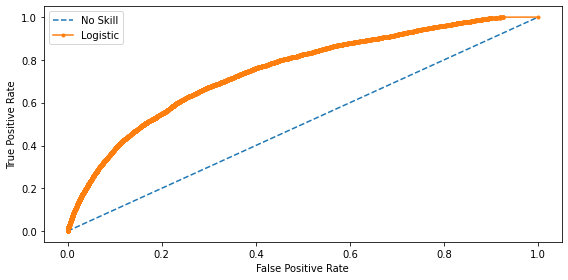

In [262]:
# roc curve and auc
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
model_logistic = LogisticRegression(penalty='l1',solver='liblinear')
model_logistic.fit(X_train, y_train)
model_logistic.score(X_test,y_test) 
#running logistic regression with L1 penalty

# predict probabilities
lr_probs = model_logistic.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_probs = [0 for _ in range(len(y_test))]
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

Zero improvement from previous model with additional features.

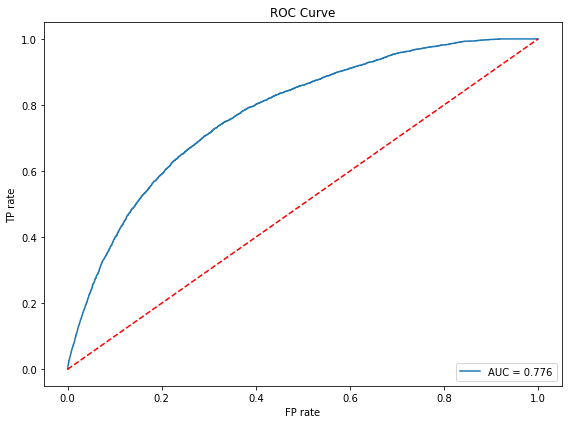

In [263]:
model_default = XGBClassifier(base_score=sum(df5['isFraud'])/df5.shape[0])
#XG BOOST with base_score using portion of fraud
model_default.fit(X_train, y_train)
y_pred_d = model_default.predict_proba(X_test)[:,1]
#Prediction of y_test

###process to generate ROC curve
fp_r, tp_r, t = metrics.roc_curve(y_test, y_pred_d)
auc = metrics.auc(fp_r, tp_r)
plt.figure(figsize=(8, 6))
plt.plot(fp_r, tp_r, label="AUC = %.3f" % auc)
plt.plot([0,1],[0,1],"r--")
plt.ylabel("TP rate")
plt.xlabel("FP rate")
plt.legend(loc=4)
plt.title("ROC Curve")
plt.show()
###

AUC even decreased slightly from previous XGBoost model (.782 to .776). 

### Result

XGBoost shows better prediction than the logistic regression. But, the additional features do not provide any benefit for either of the modeling frameworks. 

### Future work

First, maybe I can do more works on the modeling frameworks side. Even within XGBoost, I can try to look for better parameter tuning. I tried for SMOTE (Synthetic Minority Oversampling Technique), but it did not work well. I added the work related to the SMOTE at the end of this document.

Second, and which is more important than the modeling framework, is feature engineering. It can bring more impact with an increase in predictive performance. One idea that I could not apply was using previous Fraud records as a predictor. One problem that holds me back is that I don't know the timing of the Fraud indicator update for the transactions. At the timing of one transaction, I am unsure how to set a lag for past fraud data. These kinds of predictors were used in my past projects. There were features like "days_since_last_'target'", "number_of_'target'_happened_during_months' and etc. If I had a better background with this data and had more time, I could generate those features and test them in the model.


## Appendix: SMOTE

The idea of SMOTE is to oversample the target label with fewer counts (in our case isFraud==True) until the sample of each label becomes 50/50. It makes the imbalanced classification task into a balanced classification task. Contrary to expectations, the SMOTE could not improve the model. I will just add code for SMOTE as an appendix. 

In [267]:
X_train_smote, y_train_smote = SMOTE(random_state=10).fit_resample(X_train, y_train)
smote_value_counts = y_train_smote['isFraud'].value_counts()
print("Fraudulent transactions are %.2f%% of the test set." % (smote_value_counts[0] * 100 / len(y_train_smote)))

Fraudulent transactions are 50.00% of the test set.


In [268]:
def xgboost_search(X, y, search_verbose=1):
    params = {
        "gamma":[0.5, 1, 1.5, 2, 5],
        "max_depth":[3,4,5,6],
        "min_child_weight": [100],
        "subsample": [0.6, 0.8, 1.0],
        "colsample_bytree": [0.6, 0.8, 1.0],
        "learning_rate": [0.1, 0.01, 0.001]
    }
    xgb = XGBClassifier(objective="binary:logistic", eval_metric="auc", use_label_encoder=False)
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=10)
    grid_search = GridSearchCV(estimator=xgb, param_grid=params, scoring="roc_auc", n_jobs=1, cv=skf.split(X,y), verbose=search_verbose)
    grid_search.fit(X, y)
    print("Best estimator: ")
    print(grid_search.best_estimator_)
    print("Parameters: ", grid_search.best_params_)
    print("Highest AUC: %.2f" % grid_search.best_score_)
    return grid_search.best_params_
#rows = random.sample(np.arange(0,len(X_train_smote.index)).tolist(), 5000)
#model_params = xgboost_search(X_train_smote.iloc[rows,], y_train_smote.iloc[rows,] )
#searched params are applied in next line. The running time is too long.

In [270]:

model = XGBClassifier(objective="binary:logistic", eval_metric="auc", use_label_encoder=False)
model.set_params(base_score=0.5, booster='gbtree',
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, 
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)
model.fit(X_train_smote, y_train_smote)




[23:19:02] WARNING: ../src/learner.cc:516: 

Parameters: { use_label_encoder } might not be used.



  This may not be accurate due to some parameters are only used in language bindings but

  passed down to XGBoost core.  Or some parameters are not used but slip through this

  verification. Please open an issue if you find above cases.






XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

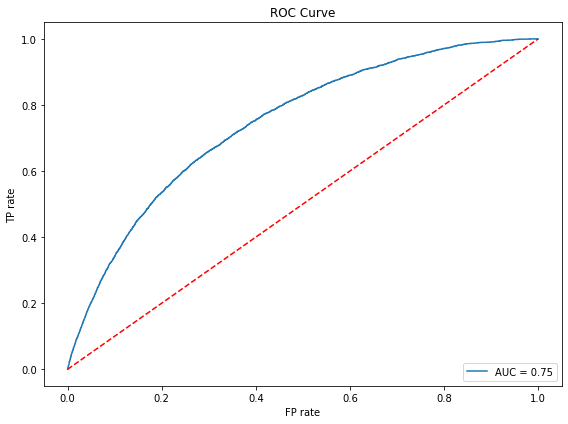

In [271]:
y_pred = model.predict_proba(X_test)[:,1]
fp_r, tp_r, t = metrics.roc_curve(y_test, y_pred)
auc = metrics.auc(fp_r, tp_r)
plt.figure(figsize=(8, 6))
plt.plot(fp_r, tp_r, label="AUC = %.2f" % auc)
plt.plot([0,1],[0,1],"r--")
plt.ylabel("TP rate")
plt.xlabel("FP rate")
plt.legend(loc=4)
plt.title("ROC Curve")
plt.show()

The perfromance was rather decreased with oversampling.